# Importar librerias

traigo las librerías necesarias para todos los pasos del ETL

In [38]:
from pytrends.request import TrendReq
import seaborn
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import os
from dotenv import load_dotenv, dotenv_values
from sqlalchemy import create_engine
import psycopg2
from psycopg2 import extras

# Extraer datos con API pytrends

utilizando la librería pytrends, seteamos idioma y uso horario de consulta

In [7]:
pt = TrendReq(hl="es-AR", tz=902, timeout=(10,25))

En este caso armaremos una tabla que nos ayude a monitorear el interés del público ante los principales candidatos para las elecciones 2023.
Google trends solo permite 5 key word por llamado, por lo cual procederemos a armar una consulta por elemento de la lista, una vez armada la consulta la guardaremos en una base, haremos otra consulta y procederemos a joinearlas por fecha.

In [8]:
kw_list= ["Larreta", "Guillermo Moreno", "Milei", "Patricia Bullrich", "Scioli", "Juan Grabois", "Pichetto", "Facundo Manes", "Wado de Pedro", "Sergio Massa"]

aux=0

for element in kw_list:
    pt.build_payload([element], timeframe="today 3-m", geo="AR", cat=396)
    
    if aux==0:
        iot = pt.interest_over_time()
        #elimino columna no necesaria
        iot.drop(columns='isPartial', inplace=True)
        aux=1
    else:
        iot_aux = pt.interest_over_time()
        iot_aux.drop(columns='isPartial', inplace=True)
        iot=pd.merge(iot, iot_aux, left_index=True, right_index=True)

Verificamos el resultado final de nuestra tabla para asegurar que todo esté correcto.

In [9]:
iot

,Larreta,Guillermo Moreno,Milei,Patricia Bullrich,Scioli,Juan Grabois,Pichetto,Facundo Manes,Wado de Pedro,Sergio Massa
date,,,,,,,,,,
2023-03-13,0,0,10,22,23,38,53,0,0,41
2023-03-14,32,0,21,42,26,0,0,0,0,19
2023-03-15,29,36,25,15,29,25,0,0,0,25
2023-03-16,31,0,22,39,0,0,0,52,0,14
2023-03-17,54,0,11,13,17,0,26,0,62,26
...,...,...,...,...,...,...,...,...,...,...
2023-06-05,56,33,35,85,11,0,94,0,0,0
2023-06-06,78,0,17,81,27,0,0,0,0,34
2023-06-07,54,27,27,64,30,0,25,0,40,0


También nos interesa crear un seguimiento de un Candidato en particular pero por región y mes, para esto realizamos una consulta similar a la anterior pero con un rango de fechas especifica y hacemos un append de los resultados.

In [10]:
kw_list= ["Larreta", "Guillermo Moreno", "Milei", "Patricia Bullrich", "Scioli", "Juan Grabois", "Pichetto", "Facundo Manes", "Wado de Pedro", "Sergio Massa"]

fecha_inic=date.today().strftime("%Y-%m-%d")
fecha_fin=date.today()-relativedelta(months=1)
fecha_fin=fecha_fin.strftime("%Y-%m-%d")

aux=0

for element in kw_list:
    pt.build_payload([element], timeframe="{} {}".format(fecha_fin, fecha_inic), geo="AR", cat=396)
    
    if aux==0:
        ibr=pt.interest_by_region("city", inc_low_vol=True, inc_geo_code=True)
        aux=1
    else:
        ibr_aux = pt.interest_by_region("city", inc_low_vol=True, inc_geo_code=True)
        #elimino columna no necesaria
        ibr_aux.drop(columns='geoCode', inplace=True)
        ibr=pd.merge(ibr, ibr_aux, left_index=True, right_index=True)

Agregamos mes de referencia para entender en qué momento se realizó la consulta

In [11]:
ibr['Mes']=date.today().strftime("%b")

chequeamos la tabla y transformamos index en columna

In [12]:
ibr

,geoCode,Larreta,Guillermo Moreno,Milei,Patricia Bullrich,Scioli,Juan Grabois,Pichetto,Facundo Manes,Wado de Pedro,Sergio Massa,Mes
geoName,,,,,,,,,,,,
Buenos Aires,AR-B,30,22,29,51,38,2,7,1,13,19,Jun
Catamarca,AR-K,100,0,0,70,0,100,0,0,0,0,Jun
Chaco,AR-H,0,0,18,28,0,0,0,0,0,0,Jun
Chubut,AR-U,62,100,43,0,38,0,84,0,0,29,Jun
Ciudad Autónoma de Buenos Aires,AR-C,67,34,40,91,48,0,19,2,20,37,Jun
Corrientes,AR-W,0,0,0,30,0,0,51,0,76,0,Jun
Córdoba,AR-X,24,8,27,43,28,0,16,0,16,9,Jun
Entre Ríos,AR-E,27,0,17,45,18,0,19,13,0,13,Jun
Formosa,AR-P,0,0,43,51,0,66,0,100,0,0,Jun


# Graficos de chequeo

Utilizando un ploteo simple realizamos gráficos comparativos de nuestros candidatos principales para poder sondear el interés del publico.

<Axes: xlabel='date'>

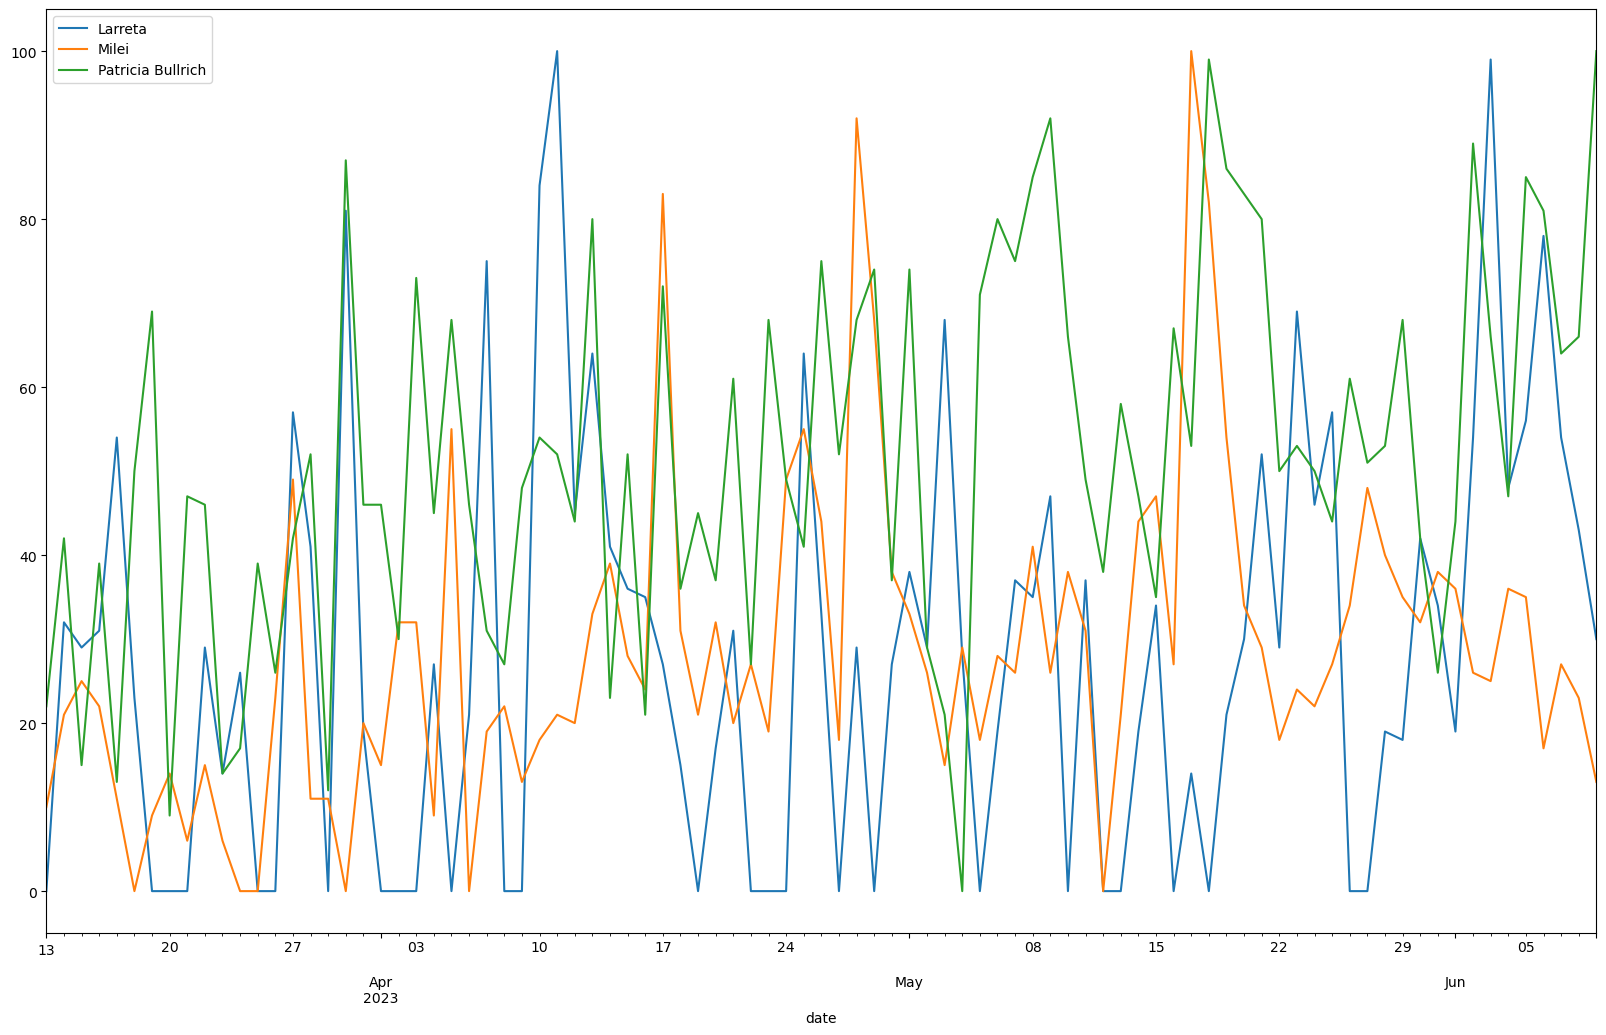

In [40]:
iot[['Larreta','Milei', 'Patricia Bullrich']].plot(figsize=(20, 12))

<Axes: xlabel='date'>

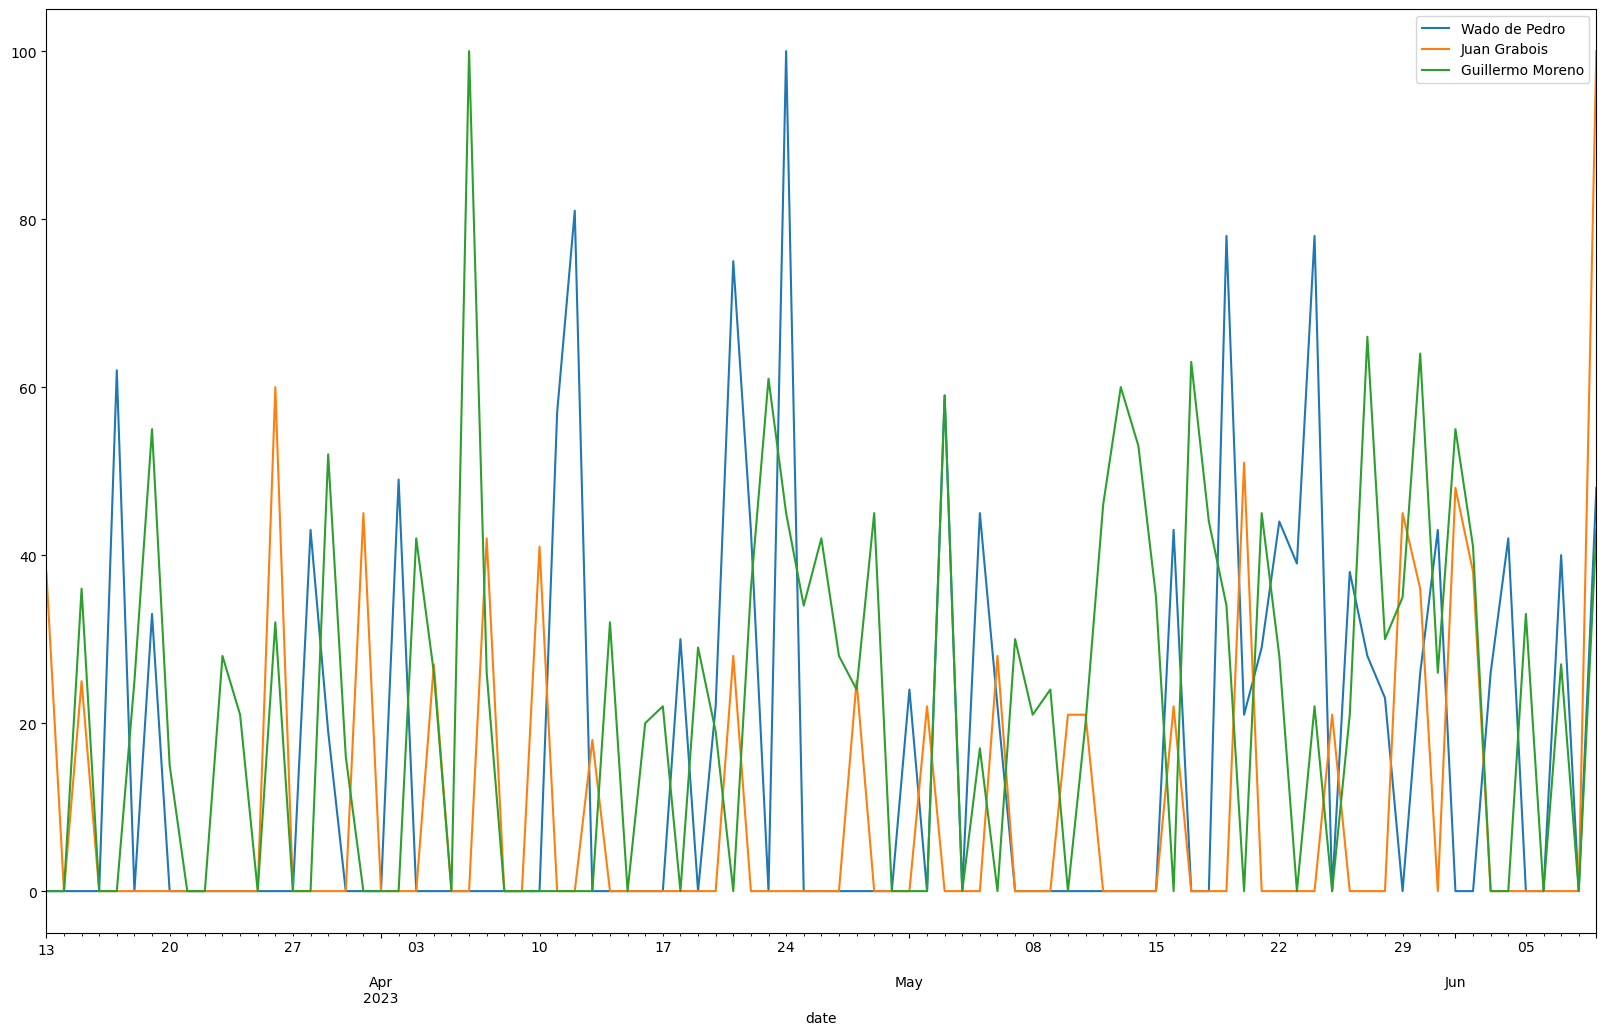

In [14]:
iot[['Wado de Pedro','Juan Grabois', 'Guillermo Moreno']].plot(figsize=(20, 12))

<Axes: xlabel='date'>

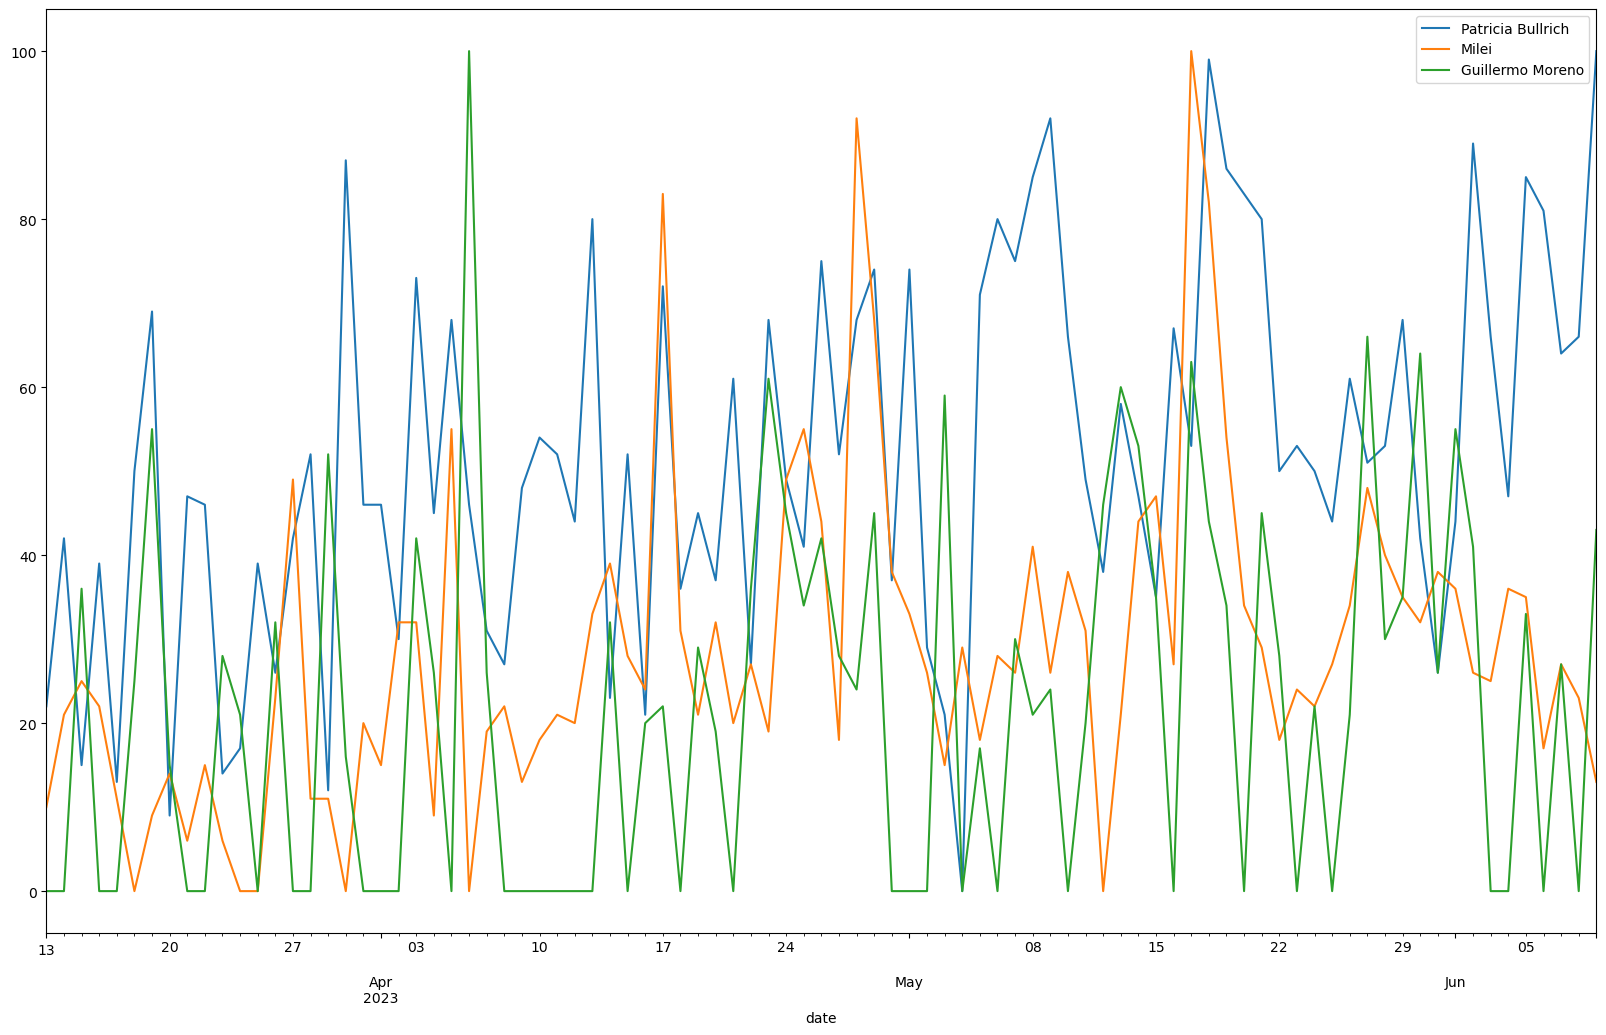

In [15]:
iot[['Patricia Bullrich','Milei', 'Guillermo Moreno']].plot(figsize=(20, 12))

# Conectarse a la DB y crear el proceso de ETL

Generamos una conexión a nuestra DB utilizando variables de entorno para mayor seguridad. La conexión la realizaremos utilizando sqlAlchemy y trabajaremos nuestros queries con psychopg.

In [103]:
load_dotenv()

connect=psycopg2.connect(host=os.getenv("AWS_REDSHIFT_HOST"), dbname=os.getenv("AWS_REDSHIFT_DBNAME"), user=os.getenv("AWS_REDSHIFT_USER"), password=os.getenv("AWS_REDSHIFT_PASSWORD"), port=os.getenv("AWS_REDSHIFT_PORT"))

cur=connect.cursor()


Trabajaremos en una primera instancia con tablas principales que almacenarán la información historica de nuestras consultas, y en paralelo tendremos otras tablas de staging que nos serviran como auxiliares para realizar el proceso de ETL. Procederemos a crerar las tablas en caso de que no estén ya generadas. También setearemos el schema con el cual trabajaremos y autocommitearemos los cambios para que queden registrados.

In [58]:
schema=os.getenv("AWS_REDSHIFT_SCHEMA")

connect.autocommit = True

cur.execute(f"""
create table if not exists {schema}.Consultas_por_fecha(
    date VARCHAR(10) distkey,
    Larreta smallint,
    Guillermo_Moreno smallint,
    Milei smallint,
    Patricia_Bullrich smallint,
    Scioli smallint,
    Juan_Grabois smallint,
    Pichetto smallint,
    Facundo_Manes smallint,
    Wado_de_Pedro smallint,
    Sergio_Massa smallint
    
) sortkey(date);
""")

cur.execute(f"""
create table if not exists {schema}.Consultas_por_region(
    geoname VARCHAR(50),
    geoCode VARCHAR(4) distkey,
    Larreta smallint,
    Guillermo_Moreno smallint,
    Milei smallint,
    Patricia_Bullrich smallint,
    Scioli smallint,
    Juan_Grabois smallint,
    Pichetto smallint,
    Facundo_Manes smallint,
    Wado_de_Pedro smallint,
    Sergio_Massa smallint,
    mes VARCHAR(20)
    
) sortkey(mes);
""")

cur.execute(f"""
create table if not exists {schema}.Consultas_por_fecha_staging(
    date VARCHAR(10) distkey,
    Larreta smallint,
    Guillermo_Moreno smallint,
    Milei smallint,
    Patricia_Bullrich smallint,
    Scioli smallint,
    Juan_Grabois smallint,
    Pichetto smallint,
    Facundo_Manes smallint,
    Wado_de_Pedro smallint,
    Sergio_Massa smallint
    
) sortkey(date);
""")

cur.execute(f"""
create table if not exists {schema}.Consultas_por_region_staging(
    geoname VARCHAR(50),
    geoCode VARCHAR(4) distkey,
    Larreta smallint,
    Guillermo_Moreno smallint,
    Milei smallint,
    Patricia_Bullrich smallint,
    Scioli smallint,
    Juan_Grabois smallint,
    Pichetto smallint,
    Facundo_Manes smallint,
    Wado_de_Pedro smallint,
    Sergio_Massa smallint,
    mes VARCHAR(20)
    
) sortkey(mes);
""") 

Para la correcta insersión será necesario resetear los index, así los mismos pasan a ser columnas

In [99]:
iot.reset_index(inplace=True)
ibr.reset_index(inplace=True)

Por otro lado transformamos el tipo de dato timestamp en datetime para facilitar el insert

In [100]:
iot['date']=iot['date'].apply(lambda x: x.date())

Luego de preparar nuestra base procederemos a pegar nuestros datos en una tabla dfe staging que nos servira de auxiliar

In [82]:
extras.execute_values(
            cur=cur,
             sql="""
                INSERT INTO Consultas_por_region_staging
                (geoname, geoCode, Larreta, Guillermo_Moreno, Milei, Patricia_Bullrich, Scioli,Juan_Grabois, Pichetto,
                Facundo_Manes, Wado_de_Pedro, Sergio_Massa, mes)
                VALUES %s;
                """,
            argslist=ibr.to_dict(orient="records"),
            template="""
                (
                    %(geoName)s, %(geoCode)s, %(Larreta)s,
                    %(Guillermo Moreno)s, %(Milei)s, %(Patricia Bullrich)s,
                    %(Scioli)s, %(Juan Grabois)s, %(Pichetto)s, %(Facundo Manes)s,
                    %(Wado de Pedro)s, %(Sergio Massa)s, %(Mes)s
                )
                """
        )
connect.commit()

In [97]:
extras.execute_values(
        cur=cur,
        sql="""
            INSERT INTO Consultas_por_fecha_staging
            (date, Larreta, Guillermo_Moreno, Milei, Patricia_Bullrich, Scioli,Juan_Grabois, Pichetto,
            Facundo_Manes, Wado_de_Pedro, Sergio_Massa)
            VALUES %s;
            """,
        argslist=iot.to_dict(orient="records"),
        template="""
            (
                %(date)s, %(Larreta)s,
                %(Guillermo Moreno)s, %(Milei)s, %(Patricia Bullrich)s,
                %(Scioli)s, %(Juan Grabois)s, %(Pichetto)s, %(Facundo Manes)s,
                %(Wado de Pedro)s, %(Sergio Massa)s
            )
            """
    )
connect.commit()

Una vez realizado esto correremos una transacción que nos permitirá borrar de la tabla principal los datos que se encuentren en staging para luego pasar la info de dicha tabla a la tabla principal (dado que es el dato más actualizado). Luego esto borramos los datos de la tabla staging para no ocupar espacio innecesariamente

In [ ]:
cur.execute(f"""
begin transaction;

delete from consultas_por_region using consultas_por_region_staging
where consultas_por_region.geocode=consultas_por_region_staging.geocode
and consultas_por_region.mes=consultas_por_region_staging.mes;

insert into consultas_por_region select * from consultas_por_region_staging;

delete from consultas_por_region_staging;

end transaction;
""")


In [104]:
cur.execute(f"""
begin transaction;

delete from consultas_por_fecha using consultas_por_fecha_staging
where consultas_por_fecha.date=consultas_por_fecha_staging.date;

insert into consultas_por_fecha select * from consultas_por_fecha_staging;

delete from consultas_por_fecha_staging;

end transaction;
""")


Commiteamos y cerramos cursor

In [105]:
connect.commit()

In [106]:
cur.close()
connect.close()